<a href="https://colab.research.google.com/github/mustafa-mohamedz/Compiler/blob/master/OR_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MRNET for knee diagnosis project**

## **Download DataSet into Google Drive**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#download the dataset.
!wget http://download.cs.stanford.edu/deep/MRNet-v1.0.zip
#unzip the dataset to google drive.
!unzip MRNet-v1.0.zip -d /content/drive/My\ Drive

## **Imports**

In [0]:
#Imports
import glob
import numpy as np
import tensorflow as tf
import pandas as pd
import tensorflow.keras as keras
from tensorflow.keras.backend import max
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling1D, Dense, Conv1D,Conv2D,AveragePooling2D, Dropout, Flatten
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

## **Data Preparation**

### **Load Data**
Get data images from drive

In [0]:
def loadData(folderName, isTraining) :
  folderName += '/0*.npy' if isTraining else '/1*.npy'
  imagesPathes = glob.glob('/content/drive/My Drive/MRNet-v1.0/train/' + folderName)
  imagesPathes.sort();
  return imagesPathes

In [0]:
def loadTestData(folderName) :
  folderName += '/*.npy'
  imagesPathes = glob.glob('/content/drive/My Drive/MRNet-v1.0/valid/' + folderName)
  imagesPathes.sort();
  return imagesPathes

### **Load Labels**

In [0]:
def loadLabels(filename, trainingLabels) :
  filename = '/content/drive/My Drive/MRNet-v1.0/' + filename
  raw_data = open(filename)
  data = np.loadtxt(raw_data, delimiter=",")
  data = data[:1000]if trainingLabels else data[-130:] 
  return data[:,1]

In [0]:
def loadTestLabels(filename) :
  filename = '/content/drive/My Drive/MRNet-v1.0/' + filename
  raw_data = open(filename)
  data = np.loadtxt(raw_data, delimiter=",")
  return data[:,1]

### **Data Generator class**
*getItem Function*

Load 3 scans (one for each view) and the thier label

In [0]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, axialPathes, coronalPathes, sagittalPathes, labels):
      self.axialPathes = axialPathes
      self.coronalPathes = coronalPathes
      self.sagittalPathes = sagittalPathes
      self.labels = labels

    def __len__(self):
      return len(self.labels)

    def add_rgb(self,grey_img):
      rgb_img = np.repeat(grey_img[...,np.newaxis], 3, -1)
      return rgb_img

    def __getitem__(self, index):
      axial_img = self.add_rgb(np.load(self.axialPathes[index]))
      coronal_img = self.add_rgb(np.load(self.coronalPathes[index]))
      sagittal_img = self.add_rgb(np.load(self.sagittalPathes[index]))
      y = np.array([self.labels[index]])
      return [axial_img, coronal_img, sagittal_img], y


### **Load All Data Pathes and Labels values**

In [0]:
#training
trainingAxialPathes = loadData(folderName = 'axial', isTraining = True)
trainingCoronalPathes = loadData(folderName = 'coronal', isTraining = True)
trainingSagittalPathes = loadData(folderName = 'sagittal', isTraining = True)

abnormal_traininglabels = loadLabels(filename = 'train-abnormal.csv', trainingLabels = True)
acl_traininglabels = loadLabels(filename = 'train-acl.csv', trainingLabels = True)
meniscus_traininglabels = loadLabels(filename = 'train-meniscus.csv', trainingLabels = True)


#validation
validationAxialPathes = loadData(folderName = 'axial', isTraining = False)
validationCoronalPathes = loadData(folderName = 'coronal', isTraining = False)
validationSagittalPathes = loadData(folderName = 'sagittal', isTraining = False)

abnormal_validationlabels = loadLabels(filename = 'train-abnormal.csv', trainingLabels = False)
acl_validationlabels = loadLabels(filename = 'train-acl.csv', trainingLabels = False)
meniscus_validationlabels = loadLabels(filename = 'train-meniscus.csv', trainingLabels = False)


#Test
testAxialPathes = loadTestData('axial')
testCoronalPathes = loadTestData('coronal')
testSagittalPathes = loadTestData('sagittal')

abnormal_testlabels = loadTestLabels('valid-abnormal.csv')
acl_testlabels = loadTestLabels('valid-acl.csv')
meniscus_testlabels = loadTestLabels('valid-meniscus.csv')

### **Create Data Generators**

In [0]:
#abnormal
abnormal_training_generator = DataGenerator(trainingAxialPathes,trainingCoronalPathes,trainingSagittalPathes,abnormal_traininglabels)
abnormal_validation_generator = DataGenerator(validationAxialPathes,validationCoronalPathes,validationSagittalPathes, abnormal_validationlabels)
abnormal_test_generator = DataGenerator(testAxialPathes,testCoronalPathes,testSagittalPathes, abnormal_testlabels)

#acl
acl_training_generator = DataGenerator(trainingAxialPathes,trainingCoronalPathes,trainingSagittalPathes,acl_traininglabels)
acl_validation_generator = DataGenerator(validationAxialPathes,validationCoronalPathes,validationSagittalPathes, acl_validationlabels)
acl_test_generator = DataGenerator(testAxialPathes,testCoronalPathes,testSagittalPathes, acl_testlabels)

#meniscus
meniscus_training_generator = DataGenerator(trainingAxialPathes,trainingCoronalPathes,trainingSagittalPathes,meniscus_traininglabels)
meniscus_validation_generator = DataGenerator(validationAxialPathes,validationCoronalPathes,validationSagittalPathes, meniscus_validationlabels)
meniscus_test_generator = DataGenerator(testAxialPathes,testCoronalPathes,testSagittalPathes, meniscus_testlabels)


##**Alexnet Model**

### **Paper Implementation**

In [0]:
#feature extractor
def getAlexNetFE():
  inputs = keras.Input(shape=(256, 256, 3))
  # 1st Convolutional Layer
  x = Conv2D(filters=96, input_shape=(256, 256, 3), kernel_size=(11, 11), strides=(4, 4), padding='same')(inputs)
  x = Activation('relu')(x)
  # Max Pooling
  x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

  # 2nd Convolutional Layer
  x = Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same')(x)
  x = Activation('relu')(x)
  # Max Pooling
  x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

  # 3rd Convolutional Layer
  x = Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
  x = Activation('relu')(x)

  # 4th Convolutional Layer
  x = Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
  x = Activation('relu')(x)

  # 5th Convolutional Layer
  x = Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
  x = Activation('relu')(x)
  # Max Pooling
  x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)
  return keras.Model(inputs, x)

In [0]:
def getVeiwANModel():
  inputs = keras.Input(shape=(256, 256, 3))
  x = getAlexNetFE()(inputs)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = max(x, axis = 0, keepdims = True)
  x = Dense(128, activation=tf.nn.relu)(x)
  x = Dropout(0.1)(x)
  x = Dense(1,activation=tf.nn.sigmoid)(x)
  return keras.Model(inputs, x)

In [0]:
def getCompleteANModel():
  axial_model = getVeiwANModel()
  coronal_model = getVeiwANModel()
  sagittal_model = getVeiwANModel()
  axial_input = keras.Input(shape = (256, 256, 3))
  coronal_input = keras.Input(shape = (256, 256, 3))
  sagittal_input = keras.Input(shape = (256, 256, 3))
  x = layers.concatenate([axial_model(axial_input), coronal_model(coronal_input), sagittal_model(sagittal_input)])
  outputs = Dense(1,activation=tf.nn.sigmoid)(x)
  model = keras.Model([axial_input,coronal_input,sagittal_input], outputs)
  return model

### **Training**

In [0]:
#alexnet abnormal model
abnormal_model = getCompleteANModel()
abnormal_model.summary()
keras.utils.plot_model(abnormal_model, "/content/drive/My Drive/AlexNet.png", show_shapes=True)
abnormal_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC'])
abnormal_model.fit(abnormal_training_generator,validation_data = abnormal_validation_generator,epochs = 100)

In [0]:
#alexnet acl model
acl_model = getCompleteANModel()
acl_model.summary()
acl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC'])
acl_model.fit(acl_training_generator,validation_data=acl_validation_generator,epochs =10)
acl_model.save("acl_AN.h5")

In [0]:
#Alexnet meniscus model
meniscus_model = getCompleteANModel()
meniscus_model.summary()
meniscus_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC'])
meniscus_model.fit(meniscus_training_generator,validation_data=meniscus_validation_generator,epochs =10)
meniscus_model.save("meniscus_AN.h5")

## **VGG 16**



### **VGG16 model layers**

In [0]:
def vggModel (input_shp) :

  vggModel = tf.keras.Sequential()
  
  # first block
  vggModel.add(Conv2D(input_shape = input_shp, filters = 64, kernel_size = (3,3), padding = "same", activation = "relu"))
  vggModel.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", activation = "relu"))
  vggModel.add(MaxPool2D(pool_size = (2, 2), strides=(2, 2)))

  # second block
  vggModel.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = "same", activation = "relu"))
  vggModel.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = "same", activation = "relu"))
  vggModel.add(MaxPool2D(pool_size = (2, 2), strides=(2, 2)))

  # third block
  vggModel.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", activation = "relu"))
  vggModel.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", activation = "relu"))
  vggModel.add(Conv2D(filters = 256, kernel_size = (3, 3), padding = "same", activation = "relu"))
  vggModel.add(MaxPool2D(pool_size = (2, 2), strides=(2, 2)))

  # forth block
  vggModel.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "relu"))
  vggModel.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "relu"))
  vggModel.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "relu"))
  vggModel.add(MaxPool2D(pool_size = (2, 2), strides=(2, 2)))

  # fifth block
  vggModel.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "relu"))
  vggModel.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "relu"))
  vggModel.add(Conv2D(filters = 512, kernel_size = (3, 3), padding = "same", activation = "relu"))
  vggModel.add(MaxPool2D(pool_size = (2, 2), strides=(2, 2)))



  vggModel.add(Flatten())

  return vggModel;

### **Merge the 3 series in one VGG model using logistic regression**


In [0]:
def getCompleteVGGModel():
  axial_VGG_model = getSingleViewTLModel(vggModel(input_shp = (256, 256, 3)))
  axial_VGG_model.summary()
  coronal_VGG_model = getSingleViewTLModel(vggModel(input_shp = (256, 256, 3)))
  sagittal_VGG_model = getSingleViewTLModel(vggModel(input_shp = (256, 256, 3)))


  axial_VGG_input = keras.Input(shape = (256, 256, 3))
  coronal_VGG_input = keras.Input(shape = (256, 256, 3))
  sagittal_VGG_input = keras.Input(shape = (256, 256, 3))

  VGG_x = layers.concatenate([axial_VGG_model(axial_VGG_input), coronal_VGG_model(coronal_VGG_input), sagittal_VGG_model(sagittal_VGG_input)])
  VGG_outputs = Dense(1, activation = tf.nn.sigmoid)(VGG_x)
  model = keras.Model([axial_VGG_input, coronal_VGG_input, sagittal_VGG_input], VGG_outputs)

  return model

### **Training Models using VGG 16**

In [0]:
# abnormal VGG model
abnormal_VGG_model = getCompleteVGGModel()
abnormal_VGG_model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])
history_abnormal = abnormal_VGG_model.fit(abnormal_training_generator, validation_data = abnormal_validation_generator, epochs = 10)
abnormal_VGG_model.save("/content/drive/My Drive/abnormal_VGG.h5")

In [0]:
# acl VGG model
acl_VGG_model = getCompleteVGGModel()
acl_VGG_model.summary()
acl_VGG_model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])
history_acl = acl_VGG_model.fit(acl_training_generator, validation_data = acl_validation_generator, epochs = 10)
acl_VGG_model.save("/content/drive/My Drive/acl_VGG.h5")

In [0]:
# meniscus VGG model
meniscus_VGG_model = getCompleteVGGModel()
meniscus_VGG_model.summary()
meniscus_VGG_model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])
history_meniscus = meniscus_VGG_model.fit(meniscus_training_generator, validation_data = meniscus_validation_generator, epochs = 10)
meniscus_VGG_model.save("/content/drive/My Drive/meniscus_VGG.h5")

In [0]:
#abnormal model
abnormal_score = abnormal_model.evaluate(abnormal_test_generator)
print (abnormal_score)

In [0]:
#acl model
acl_score = acl_model.evaluate(acl_test_generator)
print (acl_score)

In [0]:
#evaluate
meniscus_score = model.evaluate(meniscus_test_generator)
print (meniscus_score)

## **ResNet Model**

### **Build the identity block**




In [0]:
def identity_block(x, f, filters, stage, block):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters    
    x_shortcut = x
    
    # Main Path
    # First component of main path
    x = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis = 3, name = bn_name_base + '2a')(x)
    x = Activation('relu')(x)
    
    # Second component of main path
    x = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis = 3, name = bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    # Third component of main path
    x = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis = 3, name = bn_name_base + '2c')(x)

    # Add shortcut value to main path
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
        
    return x

### **Build the convolutional block**

In [0]:
def convolutional_block(x, f, filters, stage, block, s = 2):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'    
    F1, F2, F3 = filters
    x_shortcut = x

    # Main Path
    # First component of main path 
    x = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis = 3, name = bn_name_base + '2a')(x)
    x = Activation('relu')(x)
    # Second component of main path
    x = Conv2D(F2, (f, f), strides = (1,1), padding='same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis = 3, name = bn_name_base + '2b')(x)
    x = Activation('relu')(x)
    # Third component of main path
    x = Conv2D(F3, (1, 1), strides = (1,1), padding='valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis = 3, name = bn_name_base + '2c')(x)

    # Shortcut Path
    x_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding='valid', name = conv_name_base + '1',
                          kernel_initializer = glorot_uniform(seed=0))(x_shortcut)
    x_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(x_shortcut)

    # Add shortcut value to main path
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
  
    return x

### **ResNet model (50 layers)**

In [0]:
def ResNet50(input_shape=(256, 256, 3)):

    x_input = Input(input_shape)
    x = ZeroPadding2D((3, 3))(x_input)
    
    # Stage 1
    x = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(x)
    x = BatchNormalization(axis = 3, name = 'bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Stage 2
    x = convolutional_block(x, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')

    x = max(x, axis = 0, keepdims = True)

    # Stage 3
    x = convolutional_block(x, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')

    # Stage 4
    x = convolutional_block(x, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')

    # Stage 5
    x = convolutional_block(x, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')

    x = AveragePooling2D()(x)
    
    # output layer
    x = Flatten()(x)
    x = Dense(1, activation='softmax', name='fc' + str(1), kernel_initializer = glorot_uniform(seed=0))(x)
    
    # Create model
    model = Model(inputs = x_input, outputs = x, name='ResNet50')

    return model

### **Build the model's graph**

In [0]:
model = ResNet50((256, 256, 3))

### **Get a ResNet for each series**

In [0]:
def getSingleViewResNetModel(base_model):
  inputs = Input(shape=(256, 256, 3))
  x = base_model(inputs)
  x = Dense(512, activation=tf.nn.relu)(x)
  x = Dropout(0.2)(x)
  x = Dense(128, activation=tf.nn.relu)(x)
  x = Dropout(0.1)(x)
  outputs = Dense(1,activation=tf.nn.sigmoid)(x)
  model = keras.Model(inputs, outputs)
  return model

### **Merge the 3 series in one ResNet model**

In [0]:
def getCompleteResNetModel():
  axial_model = getSingleViewResNetModel(ResNet50((256, 256, 3)))
  coronal_model = getSingleViewResNetModel(ResNet50((256, 256, 3)))
  sagittal_model = getSingleViewResNetModel(ResNet50((256, 256, 3)))
  axial_input = keras.Input(shape = (256, 256, 3))
  coronal_input = keras.Input(shape = (256, 256, 3))
  sagittal_input = keras.Input(shape = (256, 256, 3))
  x = layers.concatenate([axial_model(axial_input), coronal_model(coronal_input), sagittal_model(sagittal_input)])
  outputs = Dense(1,activation=tf.nn.sigmoid)(x)
  model = keras.Model([axial_input,coronal_input,sagittal_input], outputs)
  return model

### **Train the ResNet model**

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   (1, 1)               14092034    input_8[0][0]                    
____________________________________________________________________________________________

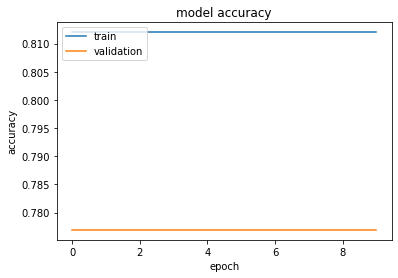

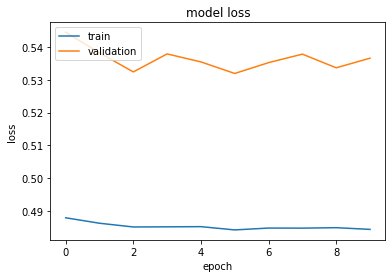

In [0]:
# Trainig
# Abnormal model
abnormal_mode = getCompleteResNetModel()
abnormal_mode.summary()
abnormal_mode.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_history = abnormal_mode.fit(abnormal_training_generator,validation_data=abnormal_validation_generator,epochs = 10)
abnormal_mode.save("/content/drive/My Drive/ResNet(abnormal)1.h5")

# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



In [0]:
# ACL model
acl_model = getCompleteResNetModel()
acl_model.summary()
acl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_history = acl_model.fit(acl_training_generator,validation_data=acl_validation_generator,epochs=5)
acl_model.save("/content/drive/My Drive/ResNet(acl).h5")

# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (1, 1)               14092034    input_19[0][0]                   
____________________________________________________________________________________________

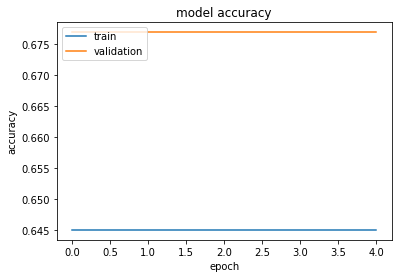

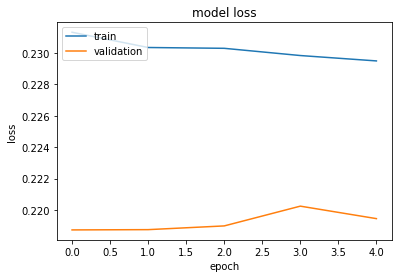

In [0]:
# Meniscus model
meniscus_model = getCompleteResNetModel()
meniscus_model.summary()
meniscus_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_history = meniscus_model.fit(meniscus_training_generator,validation_data=meniscus_validation_generator,epochs=5)
meniscus_model.save("/content/drive/My Drive/ResNet(meniscus).h5")

# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### **Test ResNet Models**

In [0]:
# Abnormal model
abnormal_score = abnormal_mode.evaluate(abnormal_test_generator)
print (abnormal_score)

120/120 [==============================] - 141s 1s/step - loss: 0.5121 - accuracy: 0.7917
[0.5121093988418579, 0.7916666865348816]


In [0]:
# ACL model
acl_score = acl_model.evaluate(acl_test_generator)
print (acl_score)

120/120 [==============================] - 216s 2s/step - loss: 0.8613 - accuracy: 0.5500
[0.8613349199295044, 0.550000011920929]


In [0]:
# Meniscus Model
meniscus_score = acl_model.evaluate(meniscus_test_generator)
print (meniscus_score)

120/120 [==============================] - 20s 170ms/step - loss: 0.8373 - accuracy: 0.5667
[0.837289035320282, 0.5666666626930237]


## **Inception V3 Model**

### **Inception V3 Implementation**

In [0]:
def inception_v3(shape=(299, 299, 3)):
    input = Input(shape=shape)
    
    x = conv2d_bn(input, 32, (3, 3), strides=(2, 2), padding='valid')
    x = conv2d_bn(x, 32, (3, 3), padding='valid')
    x = conv2d_bn(x, 64, (3, 3))
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv2d_bn(x, 80, (1, 1), padding='valid')
    x = conv2d_bn(x, 192, (3, 3), padding='valid')
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = inception_fig_5(x)
    x = inception_fig_5(x)
    x = inception_fig_5(x)

    x = dims_adj_1(x)

    x = inception_fig_6(x)
    x = inception_fig_6(x)
    x = inception_fig_6(x)
    x = inception_fig_6(x)
    x = inception_fig_6(x)

    x = dims_adj_2(x)

    x = inception_fig_7(x)
    x = inception_fig_7(x)

    x = GlobalAveragePooling2D()(x)
    x = max(x, axis = 0, keepdims = True)
    x = Dense(1, activation='sigmoid')(x)

    return Model(input, x)


def conv2d_bn(input, filters_num, kernel_size, strides=(1, 1), padding='same'):
    x = Conv2D(filters_num, kernel_size, strides=strides, padding=padding)(input)
    x = BatchNormalization(axis=3, scale=False)(x)
    x = Activation('relu')(x)
    return x


def inception_fig_5(input):
    line1 = conv2d_bn(input, 64, (1, 1))
    line1 = conv2d_bn(line1, 96, (3, 3))
    line1 = conv2d_bn(line1, 96, (3, 3))

    line2 = conv2d_bn(input, 48, (1, 1))
    line2 = conv2d_bn(line2, 64, (3, 3))

    line3 = AveragePooling2D((3, 3), strides=(1, 1), padding="same")(input)
    line3 = conv2d_bn(line3, 64, (1, 1))

    line4 = conv2d_bn(input, 64, (1, 1))

    return layers.concatenate([line1, line2, line3, line4], axis=3)


def inception_fig_6(input):
    line1 = conv2d_bn(input, 128, (1, 1))
    line1 = conv2d_bn(line1, 128, (1, 7))
    line1 = conv2d_bn(line1, 128, (7, 1))
    line1 = conv2d_bn(line1, 128, (1, 7))
    line1 = conv2d_bn(line1, 192, (7, 1))

    line2 = conv2d_bn(input, 128, (1, 1))
    line2 = conv2d_bn(line2, 128, (1, 7))
    line2 = conv2d_bn(line2, 192, (7, 1))

    line3 = AveragePooling2D((3, 3), strides=(1, 1), padding="same")(input)
    line3 = conv2d_bn(line3, 192, (1, 1))

    line4 = conv2d_bn(input, 192, (1, 1))

    return layers.concatenate([line1, line2, line3, line4], axis=3)


def inception_fig_7(input):
    line1 = conv2d_bn(input, 448, (1, 1))
    line1 = conv2d_bn(line1, 384, (3, 3))
    line1_1 = conv2d_bn(line1, 384, (1, 3))
    line1_2 = conv2d_bn(line1, 384, (3, 1))

    line2 = conv2d_bn(input, 384, (1, 1))
    line2_1 = conv2d_bn(line2, 384, (1, 3))
    line2_2 = conv2d_bn(line2, 384, (3, 1))

    line3 = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(input)
    line3 = conv2d_bn(line3, 192, (1, 1))

    line4 = conv2d_bn(input, 320, (1, 1))

    return layers.concatenate([line1_1, line1_2, line2_1, line2_2, line3, line4], axis=3)


#adjust dimensions to match those in paper
def dims_adj_1(input):
    line1 = conv2d_bn(input, 64, (1, 1))
    line1 = conv2d_bn(line1, 96, (3, 3))
    line1 = conv2d_bn(line1, 96, (3, 3), strides=(2, 2), padding="valid")

    line2 = conv2d_bn(input, 384, (3, 3), strides=(2, 2), padding="valid")

    line3 = MaxPooling2D((3, 3), strides=(2, 2), padding="valid")(input)

    return layers.concatenate([line1, line2, line3], axis=3)


def dims_adj_2(input):
    line1 = conv2d_bn(input, 192, (1, 1))
    line1 = conv2d_bn(line1, 320, (3, 3), strides=(2, 2), padding='valid')

    line2 = conv2d_bn(input, 192, (1, 1))
    line2 = conv2d_bn(line2, 192, (1, 7))
    line2 = conv2d_bn(line2, 192, (7, 1))
    line2 = conv2d_bn(line2, 192, (3, 3), strides=(2, 2), padding='valid')

    line3 = MaxPooling2D((3, 3), strides=(2, 2), padding="valid")(input)

    return layers.concatenate([line1, line2, line3], axis=3)

### **Merge the 3 Inception V3 series in one model**

In [0]:
def getCompleteInceptionV3Model():
  axial_model = inception_v3((256, 256, 3))
  coronal_model = inception_v3((256, 256, 3))
  sagittal_model = inception_v3((256, 256, 3))
  axial_input = Input(shape = (256, 256, 3))
  coronal_input = Input(shape = (256, 256, 3))
  sagittal_input = Input(shape = (256, 256, 3))
  x = layers.concatenate([axial_model(axial_input), coronal_model(coronal_input), sagittal_model(sagittal_input)])
  outputs = Dense(1,activation=tf.nn.sigmoid)(x)
  model = Model([axial_input,coronal_input,sagittal_input], outputs)
  return model

### **Training Models**

In [0]:
#abnormal model
abnormal_model = getCompleteInceptionV3Model()
abnormal_model.summary()
abnormal_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_history = abnormal_model.fit(abnormal_training_generator,validation_data=abnormal_validation_generator,epochs=10)
abnormal_model.save("/content/drive/My Drive/abnormal_InceptionV3.h5")

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model_21 (Model)                (1, 1)               21355745    input_32[0][0]                   
___________________________________________________________________________________________

ResourceExhaustedError: ignored

In [0]:
#acl model
acl_model = getCompleteInceptionV3Model()
acl_model.summary()
acl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_history = acl_model.fit(acl_training_generator,validation_data=acl_validation_generator,epochs=10)
acl_model.save("/content/drive/My Drive/acl_InceptionV3.h5")

In [0]:
#meniscus model
meniscus_model = getCompleteInceptionV3Model()
meniscus_model.summary()
meniscus_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_history = meniscus_model.fit(meniscus_training_generator,validation_data=meniscus_validation_generator,epochs =10)
meniscus_model.save("/content/drive/My Drive/meniscus_InceptionV3.h5")

In [0]:
# Plot
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

pd.DataFrame(model_history.history).plot(figsize = (8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### **Test Models**

In [0]:
#abnormal model
abnormal_score = abnormal_model.evaluate(abnormal_test_generator)
print (abnormal_score)

In [0]:
#acl model
acl_score = acl_model.evaluate(acl_test_generator)
print (acl_score)

In [0]:
#meniscus model
meniscus_score = meniscus_model.evaluate(meniscus_test_generator)
print (meniscus_score)

## **Transfer Learning**


### **Get a CNN for each series**
i.e.   axial, coronal, sagittal

In [0]:
def getSingleViewTLModel(base_model):
  base_model.trainable = False
  inputs = keras.Input(shape=(256, 256, 3))
  x = base_model(inputs)
  x = max(x, axis = 0, keepdims = True)
  x = Dense(512, activation=tf.nn.relu)(x)
  x = Dropout(0.2)(x)
  x = Dense(128, activation=tf.nn.relu)(x)
  x = Dropout(0.1)(x)
  outputs = Dense(1,activation=tf.nn.sigmoid)(x)
  model = keras.Model(inputs, outputs)
  keras.utils.plot_model(model, "/content/drive/My Drive/getSingleViewTLModel.png", show_shapes=True)

  return model

### **Merge the 3 series in one model using logistic regression**

In [0]:
def getCompleteTLModel():
  axial_model = getSingleViewTLModel(keras.applications.ResNet50(weights='imagenet', include_top = False, 
                                                                      input_shape = (256, 256, 3), pooling ='avg'))
  coronal_model = getSingleViewTLModel(keras.applications.ResNet50(weights='imagenet', include_top = False, 
                                                                      input_shape = (256, 256, 3), pooling ='avg'))
  sagittal_model = getSingleViewTLModel(keras.applications.ResNet50(weights='imagenet', include_top = False, 
                                                                      input_shape = (256, 256, 3), pooling ='avg'))
  axial_input = keras.Input(shape = (256, 256, 3))
  coronal_input = keras.Input(shape = (256, 256, 3))
  sagittal_input = keras.Input(shape = (256, 256, 3))
  x = layers.concatenate([axial_model(axial_input), coronal_model(coronal_input), sagittal_model(sagittal_input)])
  outputs = Dense(1,activation=tf.nn.sigmoid)(x)
  model = keras.Model([axial_input,coronal_input,sagittal_input], outputs)
  return model

### **Training Models**

In [0]:
#abnormal model
abnormal_model = getCompleteTLModel()
abnormal_model.summary()
abnormal_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
abnormal_model.fit(abnormal_training_generator,validation_data=abnormal_validation_generator,epochs=10)
abnormal_model.save("/content/drive/My Drive/abnormal_TL.h5")

Model: "model_43"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_99 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_100 (InputLayer)          [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_101 (InputLayer)          [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model_40 (Model)                (1, 1)               24702593    input_99[0][0]                   
___________________________________________________________________________________________

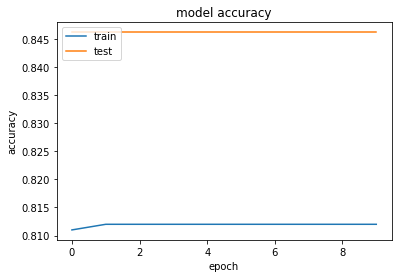

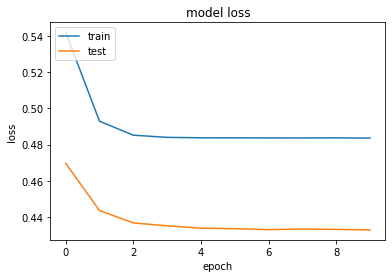

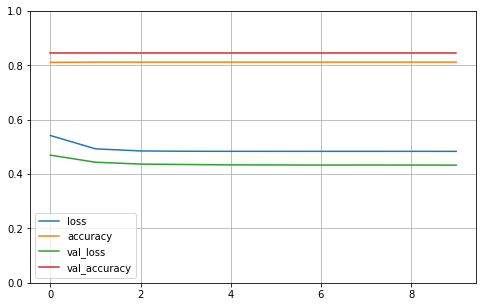

In [0]:
#acl model
acl_model = getCompleteTLModel()
acl_model.summary()
acl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_history = acl_model.fit(acl_training_generator,validation_data=acl_validation_generator,epochs=10)
acl_model.save("/content/drive/My Drive/acl_TL.h5")

# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

pd.DataFrame(model_history.history).plot(figsize = (8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()




In [0]:
#meniscus model
meniscus_model = getCompleteTLModel()
meniscus_model.summary()
meniscus_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_history = meniscus_model.fit(meniscus_training_generator,validation_data=meniscus_validation_generator,epochs =10)
meniscus_model.save("/content/drive/My Drive/meniscus_TL.h5")

# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



### **Test Models**

In [0]:
#abnormal model
abnormal_score = abnormal_model.evaluate(abnormal_test_generator)
print (abnormal_score)

In [0]:
#acl model
acl_score = acl_model.evaluate(acl_test_generator)
print (acl_score)

In [0]:
#meniscus model
meniscus_score = meniscus_model.evaluate(meniscus_test_generator)
print (meniscus_score)

In [0]:
model = keras.models.load_model('/content/drive/My Drive/meniscus_TL.h5')